In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(arrow)))
suppressPackageStartupMessages(suppressWarnings(library(platetools)))

In [2]:
cell_type <- "PBMC"

In [3]:
# set the path to the cell count data
cell_count_file <- file.path(paste0("./results/",cell_type,"_cell_counts.parquet"))

# Read in the cell count data
cell_count_df <- arrow::read_parquet(cell_count_file)
head(cell_count_df)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Metadata_number_of_singlecells,Metadata_Well,Metadata_Treatment
<chr>,<int>,<chr>,<chr>
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS
LPS_0.010_ug_per_ml_DMSO_0.025_%,34618,B02,LPS


In [4]:
# aggregate the cell counts oneoneb_Metadata_Treatment_Dose_Inhibitor_Dose with mean and sd
cell_count_df_agg <- cell_count_df %>%
  group_by(oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
  summarize(mean = mean(Metadata_number_of_singlecells), sd = sd(Metadata_number_of_singlecells), n = n(), CI = 1.96*sd/sqrt(n))
head(cell_count_df_agg)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,mean,sd,n,CI
<chr>,<dbl>,<dbl>,<int>,<dbl>
DMSO_0.100_%_DMSO_0.025_%,27092.30,2234.109,215130,9.440823
DMSO_0.100_%_DMSO_1.000_%,30130.24,1492.454,120237,8.436027
DMSO_0.100_%_Z-VAD-FMK_100.000_uM,41939.13,3795.819,166251,18.246493
DMSO_0.100_%_Z-VAD-FMK_30.000_uM,43499.34,1507.774,173789,7.088937
Disulfiram_0.100_uM_DMSO_0.025_%,28784.55,1157.504,114956,6.691336
Disulfiram_1.000_uM_DMSO_0.025_%,30369.71,1892.059,120990,10.661443


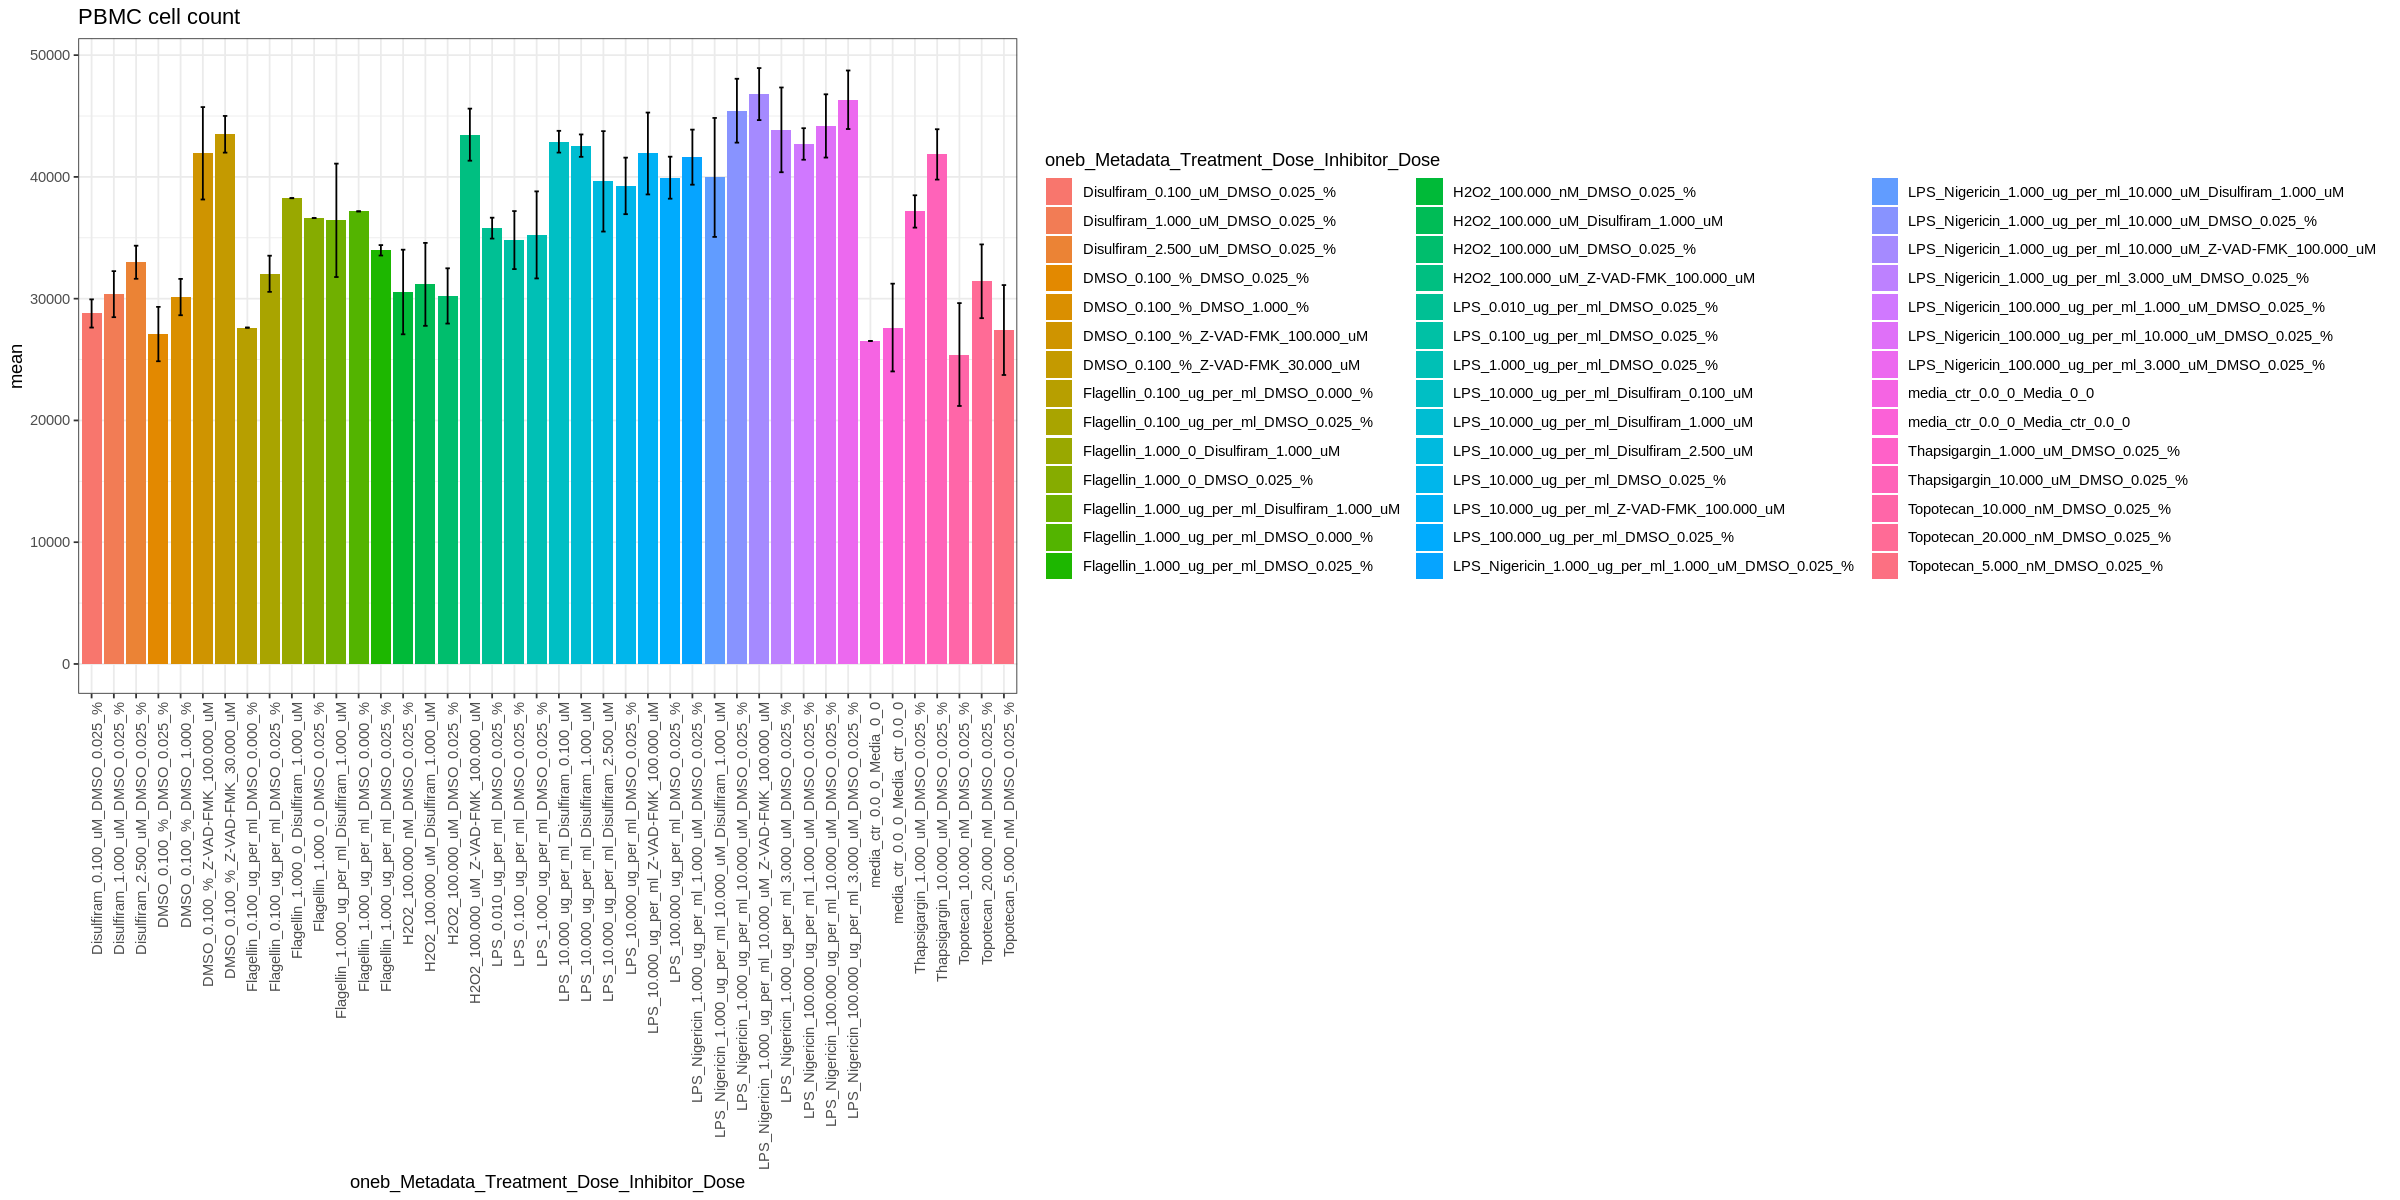

In [5]:
# set plot dimensions
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
# plot the data in a barplot
cell_count_bar <- (
    ggplot(
        data = cell_count_df_agg,
        aes(
            x = oneb_Metadata_Treatment_Dose_Inhibitor_Dose,
            y = mean,
            fill = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_bar(stat = "identity")
    + theme_bw()
    # rotate the x axis labels
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + ggtitle(paste0(cell_type, " cell count"))
    # add error bars
    + geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), width = 0.2)
)
cell_count_bar


In [6]:
# aggregate the cell counts oneoneb_Metadata_Treatment_Dose_Inhibitor_Dose with mean and sd
cell_count_df_well <- cell_count_df %>%
  group_by(Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
  summarize(mean = mean(Metadata_number_of_singlecells))
# rename mean to n 
cell_count_df_well <- rename(cell_count_df_well, n = mean)

head(cell_count_df_well)

`summarise()` has grouped output by 'Metadata_Well'. You can override using the
`.groups` argument.


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,n
<chr>,<chr>,<dbl>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,34618
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,35299
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,41185
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,44014
B06,DMSO_0.100_%_DMSO_0.025_%,25314
B07,DMSO_0.100_%_DMSO_0.025_%,26718


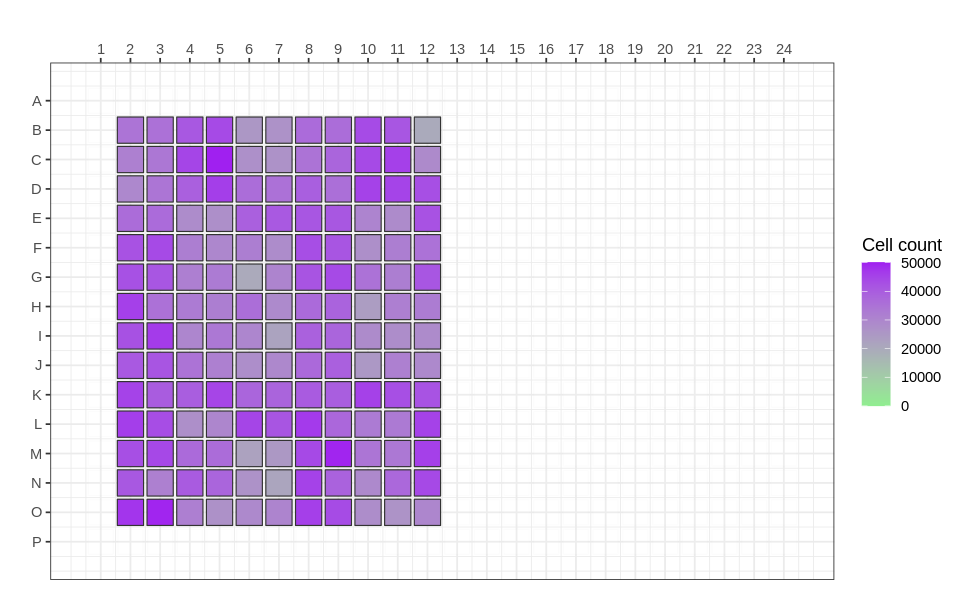

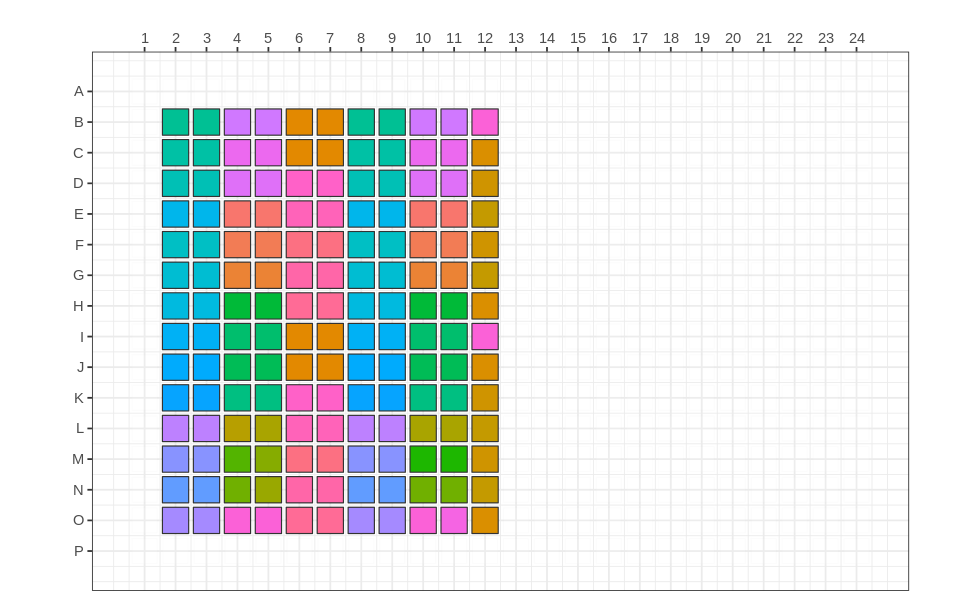

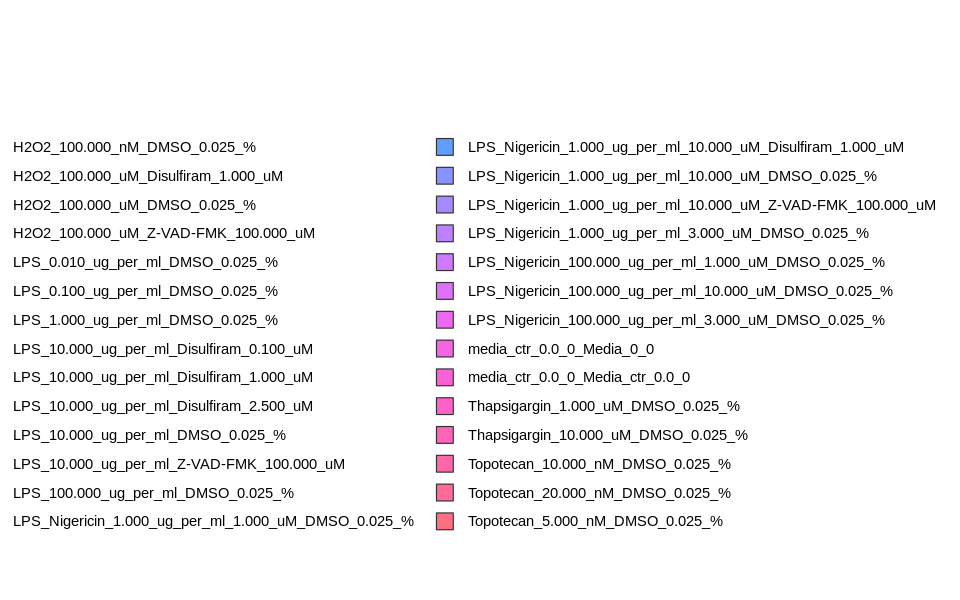

In [7]:
# plate visualization using plate tools

# set plot dimensions
width <- 8
height <- 5
options(repr.plot.width = width, repr.plot.height = height)

suppressWarnings({ 
plate_replicate_gg_count <-(
    platetools::raw_map(
        data = cell_count_df_well$n,
        well = cell_count_df_well$Metadata_Well,
        plate = 384,
        size = 8
    )
    + ggplot2::scale_fill_gradient(
        name = "Cell count",
        low = "lightgreen",
        high = "purple",
        limits = c(0, max(cell_count_df_well$n))
    )
)
})

plate_replicate_gg_count

suppressWarnings({ 
plate_replicate_gg_treatment <-(
    platetools::raw_map(
        data = cell_count_df_well$oneb_Metadata_Treatment_Dose_Inhibitor_Dose,
        well = cell_count_df_well$Metadata_Well,
        plate = 384,
        size = 8
    )
)
})
# get the legend from the cell count plot
plate_replicate_gg_treatment_legend <- plate_replicate_gg_treatment + guides(fill = guide_legend(override.aes = list(size = 5)))
# remove legend 
plate_replicate_gg_treatment <- plate_replicate_gg_treatment + theme(legend.position = "none")
plate_replicate_gg_treatment
plate_replicate_gg_treatment_legend